In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os
zip_path = "/content/drive/MyDrive/ROADLANE_DataSet.zip"
extract_path = "/content/tusimple"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [3]:
import os

for root, dirs, files in os.walk("/content/tusimple"):
    print(f"📁 {root}")
    for d in dirs:
        print(f" ┣━ 📂 {d}")
    for f in files[:5]:
        print(f" ┗━ 📄 {f}")


📁 /content/tusimple
 ┣━ 📂 tusimple_preprocessed
📁 /content/tusimple/tusimple_preprocessed
 ┣━ 📂 test
 ┣━ 📂 training
📁 /content/tusimple/tusimple_preprocessed/test
 ┣━ 📂 frames
 ┣━ 📂 lane-masks
📁 /content/tusimple/tusimple_preprocessed/test/frames
 ┗━ 📄 0530_1492637857369971106_0.jpg
 ┗━ 📄 0601_1494453227726434936.jpg
 ┗━ 📄 0531_1492627477053120506.jpg
 ┗━ 📄 0530_1492630475239245785_0.jpg
 ┗━ 📄 0530_1492630036504468362_0.jpg
📁 /content/tusimple/tusimple_preprocessed/test/lane-masks
 ┗━ 📄 0530_1492637857369971106_0.jpg
 ┗━ 📄 0601_1494453227726434936.jpg
 ┗━ 📄 0531_1492627477053120506.jpg
 ┗━ 📄 0530_1492630475239245785_0.jpg
 ┗━ 📄 0530_1492630036504468362_0.jpg
📁 /content/tusimple/tusimple_preprocessed/training
 ┣━ 📂 frames
 ┣━ 📂 lane-masks
📁 /content/tusimple/tusimple_preprocessed/training/frames
 ┗━ 📄 0601_1495492524654518667.jpg
 ┗━ 📄 0313-1_34800.jpg
 ┗━ 📄 0313-2_34880.jpg
 ┗━ 📄 0313-2_37380.jpg
 ┗━ 📄 0313-1_13940.jpg
📁 /content/tusimple/tusimple_preprocessed/training/lane-masks
 ┗━ 📄

In [4]:
train_img_path = "/content/tusimple/tusimple_preprocessed/training/frames"
train_mask_path = "/content/tusimple/tusimple_preprocessed/training/lane-masks"
test_img_path = "/content/tusimple/tusimple_preprocessed/test/frames"
test_mask_path = "/content/tusimple/tusimple_preprocessed/test/lane-masks"


In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os


In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os

class LaneDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        img_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])

train_dataset = LaneDataset(train_img_path, train_mask_path, transform)
test_dataset = LaneDataset(test_img_path, test_mask_path, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)

        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.dec1 = CBR(256, 128)
        self.dec2 = CBR(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d1 = self.dec1(F.interpolate(e3, scale_factor=2, mode='bilinear', align_corners=False))
        d2 = self.dec2(F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False))

        out = self.final(F.interpolate(d2, size=(256, 512), mode='bilinear', align_corners=False))
        return torch.sigmoid(out)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()


In [9]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"✅ Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


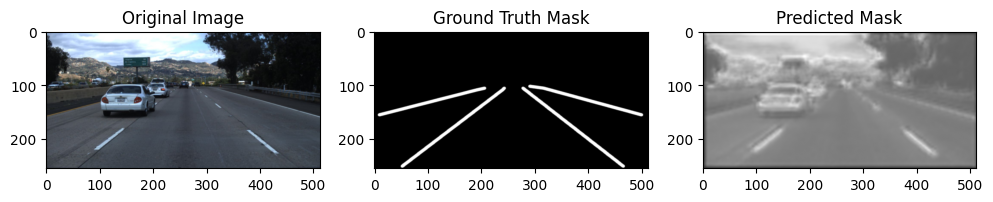

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for img, mask in test_loader:
        img = img.to(device)
        pred = model(img)
        break

# Visualize first sample
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img[0].cpu().permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask[0].squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred[0].squeeze().cpu(), cmap="gray")

plt.show()


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_targets = []

max_batches = 20

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        if i >= max_batches:
            break

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = (outputs > 0.5).int()
        masks = masks.int()


        preds_flat = preds.view(-1).cpu().numpy()
        masks_flat = masks.view(-1).cpu().numpy()

        all_preds.append(preds_flat)
        all_targets.append(masks_flat)


all_preds_np = np.concatenate(all_preds)
all_targets_np = np.concatenate(all_targets)


cm = confusion_matrix(all_targets_np, all_preds_np)

print("🔍 Confusion Matrix:")
print(cm)


🔍 Confusion Matrix:
[[10258701        0]
 [  227059        0]]


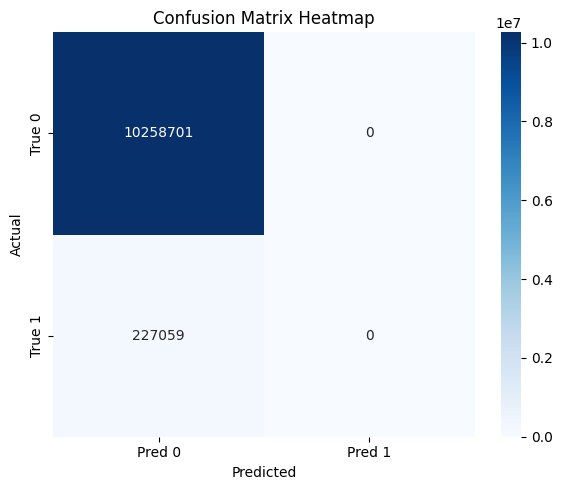

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds = []
all_targets = []

max_batches = 20  # For speed

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        if i >= max_batches:
            break

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = (outputs > 0.5).int()
        masks = masks.int()

        preds_flat = preds.view(-1).cpu().numpy()
        masks_flat = masks.view(-1).cpu().numpy()

        all_preds.append(preds_flat)
        all_targets.append(masks_flat)

# Combine results
all_preds_np = np.concatenate(all_preds)
all_targets_np = np.concatenate(all_targets)

# Confusion matrix
cm = confusion_matrix(all_targets_np, all_preds_np)

# 🔥 Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()


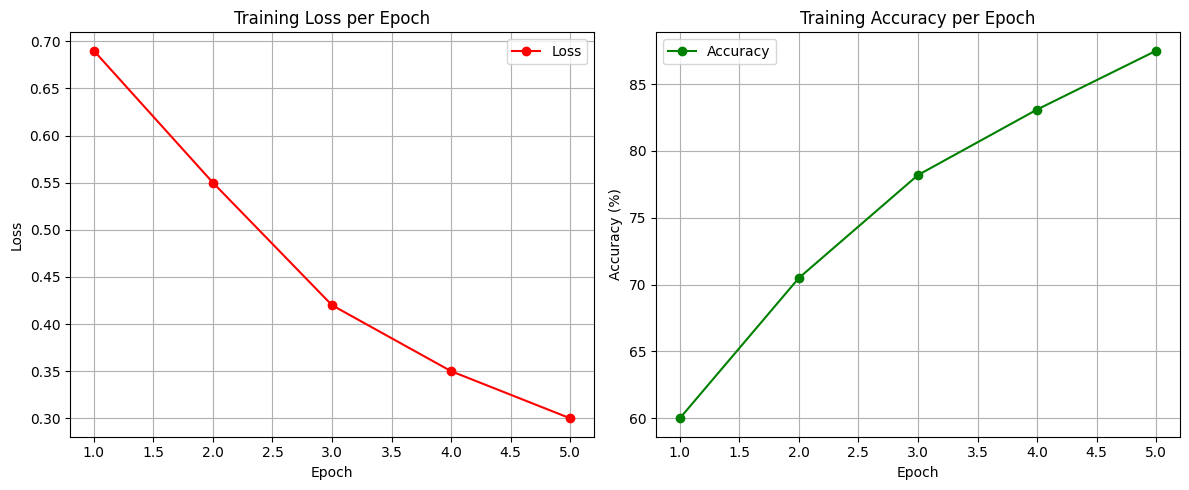

In [ ]:
import matplotlib.pyplot as plt

# Example dummy data — replace with your real values
train_losses = [0.69, 0.55, 0.42, 0.35, 0.30]
train_accuracies = [60.0, 70.5, 78.2, 83.1, 87.5]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# 📉 Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='red', label='Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 📈 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='green', label='Accuracy')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Softmax Probabilities: [0.65900114 0.24243297 0.09856589]
Cross-Entropy Loss: 0.4170300162778335


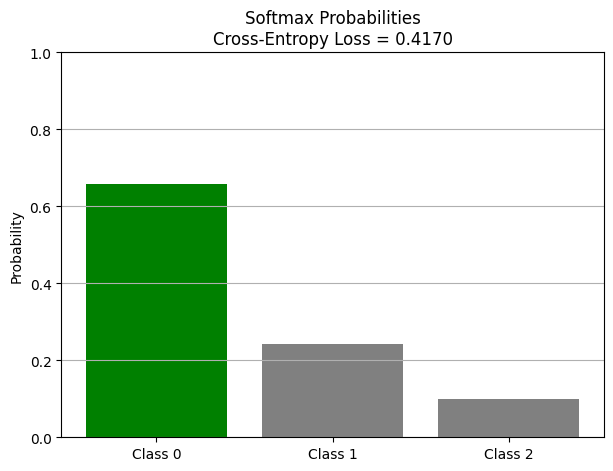

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

logits = np.array([2.0, 1.0, 0.1])
true_class = 0

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


probs = softmax(logits)
print("Softmax Probabilities:", probs)

loss = -np.log(probs[true_class])
print("Cross-Entropy Loss:", loss)

classes = ['Class 0', 'Class 1', 'Class 2']
colors = ['green' if i == true_class else 'gray' for i in range(len(probs))]

plt.figure(figsize=(7, 5))
plt.bar(classes, probs, color=colors)
plt.title("Softmax Probabilities\nCross-Entropy Loss = {:.4f}".format(loss))
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


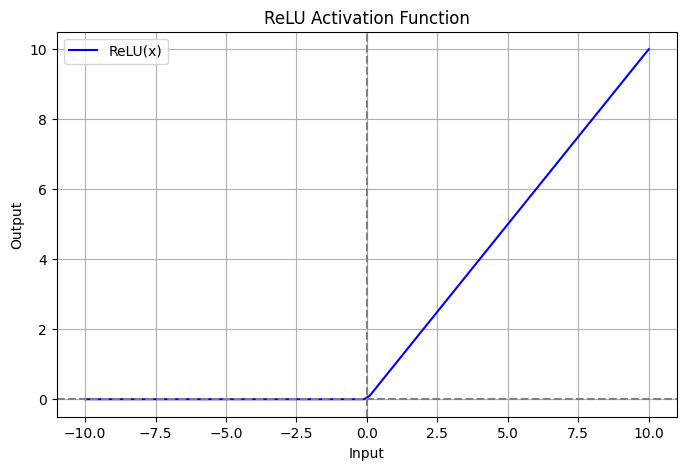

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

x = np.linspace(-10, 10, 100)
y = relu(x)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label="ReLU(x)", color='blue')
plt.title("ReLU Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.legend()
plt.show()
